In [0]:
import time
import os
import sys

import cv2
import numpy as np
import random
from PIL import Image, ImageDraw, ImageFile
# fix bugs with loading png files
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.hub import load_state_dict_from_url
from torchvision.ops.boxes import batched_nms,nms


from google.colab import files
def upload(path):
    uploaded = files.upload()
    with open(path,'wb') as fp:
        fp.write(uploaded[list(uploaded.keys())[0]])
 
def download(path):
    files.download(path)


In [0]:
def create_prior_boxes():
        """
        Create the 8732 prior (default) boxes for the SSD300, as defined in the paper.
        :return: prior boxes in center-size coordinates, a tensor of dimensions (8732, 4)
        """
        fmap_dims = {
                    'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {
                      'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {
                        'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * np.sqrt(ratio), obj_scales[fmap] / np.sqrt(ratio)])
                    if k!=len(fmaps)-1:
                            additional_scale = np.sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                    else:
                            additional_scale = 1.
                    prior_boxes.append([cx, cy, additional_scale, additional_scale])
        prior_boxes = torch.FloatTensor(prior_boxes)#.to(device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4)

        return prior_boxes

In [3]:
create_prior_boxes().size()

torch.Size([8732, 4])

In [0]:
def calc_iou_tensor(box1, box2):
    """ param: box1  tensor (N, 4) (x1,y1,x2,y2)
        param: box2  tensor (M, 4) (x1,y1,x2,y2)
        output: tensor (N, M)
    """
    N = box1.size(0)
    M = box2.size(0)

    box1 = box1.unsqueeze(1).expand(-1, M, -1)
    box2 = box2.unsqueeze(0).expand(N, -1, -1)

    # Left Top & Right Bottom
    lt = torch.max(box1[:,:,:2], box2[:,:,:2])
    rb = torch.min(box1[:,:,2:], box2[:,:,2:])

    delta = rb - lt
    delta[delta < 0] = 0
    intersect = delta[:,:,0]*delta[:,:,1]

    delta1 = box1[:,:,2:] - box1[:,:,:2]
    area1 = delta1[:,:,0]*delta1[:,:,1]
    delta2 = box2[:,:,2:] - box2[:,:,:2]
    area2 = delta2[:,:,0]*delta2[:,:,1]

    iou = intersect/(area1 + area2 - intersect)
    return iou
def cxcy_to_xy(cxcy):
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1).clamp_(0,1)
def xy_to_cxcy(xy):
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1).clamp_(0,1)
def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],  # c_x, c_y
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)
def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1)  # g_w, g_h

In [0]:

def prepare_target(boxes,labels,priors): 
  #boxes x1,y1,x2,y2
  #priors x1,y1,x2,y2
  iou = calc_iou_tensor(boxes,priors.type(torch.FloatTensor).clamp_(0,300))
  vals,inds=iou.max(dim=0)
  labels_res = labels[inds].clone()
  labels_res[vals<0.5]=0
  #### for negative mining
  mask = vals>=0.5
  pos_num = mask.sum()
  vals[mask]=0
  #values,indices=torch.topk(vals,pos_num*3)
  #---------
  #print((labels_res==-1).sum(),(labels_res!=0).sum(),pos_num.sum())
  priors_loss = cxcy_to_gcxgcy(xy_to_cxcy(boxes[inds]), xy_to_cxcy(priors))  # (8732, 4)
  return priors,labels_res,priors_loss

In [0]:
class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, bboxes):
        if random.random() < self.p:
            bboxes[:, 0], bboxes[:, 2] = 1.0 - bboxes[:, 2], 1.0 - bboxes[:, 0]
            return image.transpose(Image.FLIP_LEFT_RIGHT), bboxes
        return image, bboxes

class SSDTransformVoc:

    def __init__(self, size=(300,300),priors=[], augmentation=False, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.size = np.array(size)
        self.priors=cxcy_to_xy(priors)
        #self.anchors = Anchors()
        # base transform for images
        self.img_ts = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(), # converts to [0,1] interval
            transforms.Normalize(mean=mean, std=std)
        ])        
        self.classes = [
            "bg","person", "bird", "cat", "cow", "dog", "horse", "sheep",
            "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train",
            "bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"
        ] # bg+20 classes

        self.img_trans_aug = transforms.Compose([
            transforms.Resize(self.size),
            transforms.ColorJitter(brightness=0.125, contrast=0.5,
                saturation=0.5, hue=0.05
            ),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
        self.img_trans = transforms.Compose([
            transforms.Resize(self.size),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
        self.hflip = RandomHorizontalFlip()
        self.augmentation = augmentation
       
    def box_resize(self, img_shape, box):
        """Method to resize bounding box"""
        w,h = img_shape
        xs,ys = self.size[0]/w, self.size[1]/h
        box = np.array([int(box[0])*xs/self.size[0],int(box[1])*ys/self.size[1],int(box[2])*xs/self.size[0],int(box[3])*ys/self.size[1]])
        return box
        
    def __call__(self, img, target):
        
        boxes = []
        labels = []
        if isinstance(target, dict) and 'annotation' in target:
            # voc bboxes annotation can be list if many or dict if one (never do like this)
            objects = target['annotation']['object'] if isinstance(target['annotation']['object'], list) else [target['annotation']['object']]
            for bb in objects:
                b = bb['bndbox']
                b = [b['xmin'],b['ymin'],b['xmax'],b['ymax']]
                boxes.append(self.box_resize(img.size,b))
                labels.append(self.classes.index(bb['name']))
        else:
            for bb in target:
                boxes.append(self.box_resize(img.size,bb))
                labels.append(1)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)
        
        if self.augmentation:
            img, boxes = self.hflip(img, boxes)
            img = self.img_trans_aug(img).contiguous()
        else:
            img = self.img_trans(img).contiguous()
        priors =self.priors#cxcy_to_xy(create_prior_boxes())
        boxes,labels,for_loss = prepare_target(boxes,labels,priors)
        
        return img,(boxes,labels,for_loss)


In [0]:
def test_dataloading(ds, size=300, scale_xy=0.1, scale_wh=0.2):


    def denorm(x):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        return (x * std) + mean

    for i in range(64):
        img, ts = ds[i]
        bboxes, labels = ts[0],ts[1]
        img = np.ascontiguousarray(denorm(img.numpy().transpose(1,2,0).copy())*255).astype(np.uint8)
        w,h = img.shape[:2]

        res = bboxes

        mask = (labels >0)
        print('>>>>>>>>>>>',(labels>0).sum())
        res = res[mask].numpy()
        for bb in res:    
            img = cv2.rectangle(img, (int(bb[0]*300), int(bb[1]*300)), (int(bb[2]*300), int(bb[3]*300)), (0, 255, 0), 2)

        plt.imshow(img)
        plt.show()
        print('Shape:',img.shape,'Boxes:',labels.unique())

0it [00:00, ?it/s]

1999642624it [03:00, 12755439.88it/s]                                

>>>>>>>>>>> tensor(30)


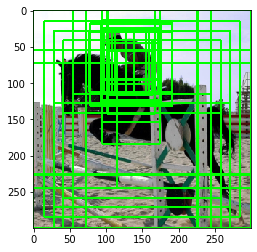

Shape: (300, 300, 3) Boxes: tensor([0, 1, 6])
>>>>>>>>>>> tensor(30)


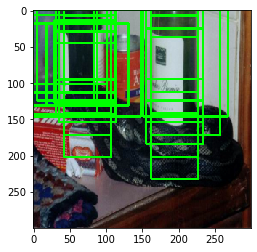

Shape: (300, 300, 3) Boxes: tensor([ 0, 15])
>>>>>>>>>>> tensor(74)


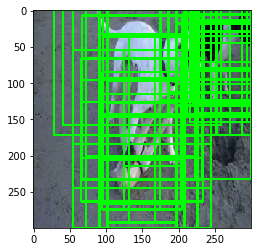

Shape: (300, 300, 3) Boxes: tensor([0, 5])
>>>>>>>>>>> tensor(62)


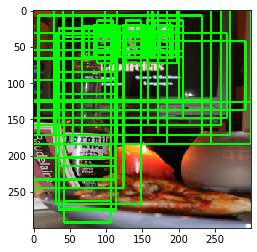

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 15, 20])
>>>>>>>>>>> tensor(20)


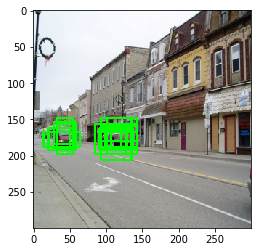

Shape: (300, 300, 3) Boxes: tensor([ 0, 12])
>>>>>>>>>>> tensor(16)


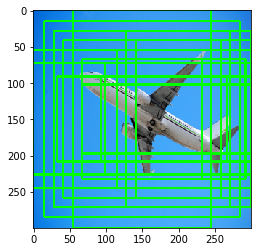

Shape: (300, 300, 3) Boxes: tensor([0, 8])
>>>>>>>>>>> tensor(71)


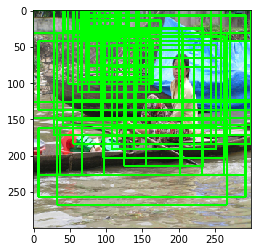

Shape: (300, 300, 3) Boxes: tensor([ 0,  1,  9, 10])
>>>>>>>>>>> tensor(10)


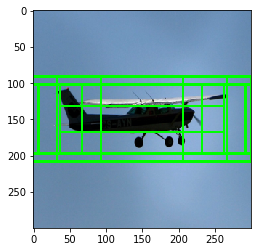

Shape: (300, 300, 3) Boxes: tensor([0, 8])
>>>>>>>>>>> tensor(179)


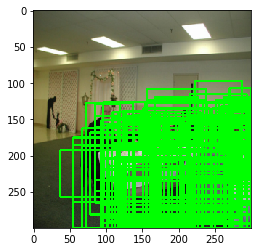

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 16, 17])
>>>>>>>>>>> tensor(12)


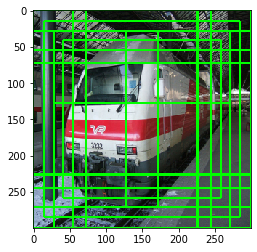

Shape: (300, 300, 3) Boxes: tensor([ 0, 14])
>>>>>>>>>>> tensor(10)


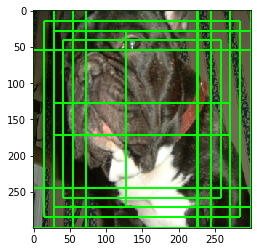

Shape: (300, 300, 3) Boxes: tensor([0, 5])
>>>>>>>>>>> tensor(13)


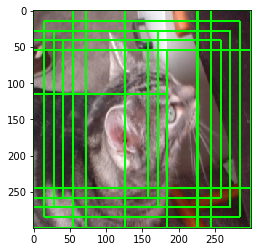

Shape: (300, 300, 3) Boxes: tensor([0, 3])
>>>>>>>>>>> tensor(9)


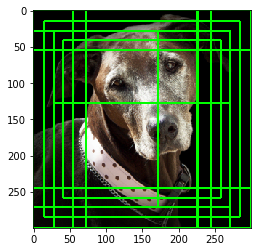

Shape: (300, 300, 3) Boxes: tensor([0, 5])
>>>>>>>>>>> tensor(35)


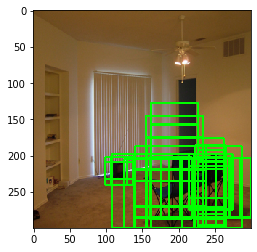

Shape: (300, 300, 3) Boxes: tensor([ 0, 16, 20])
>>>>>>>>>>> tensor(16)


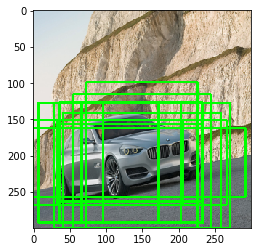

Shape: (300, 300, 3) Boxes: tensor([ 0, 12])
>>>>>>>>>>> tensor(9)


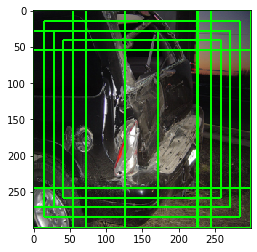

Shape: (300, 300, 3) Boxes: tensor([ 0, 12])
>>>>>>>>>>> tensor(14)


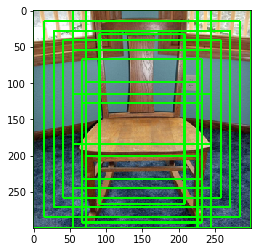

Shape: (300, 300, 3) Boxes: tensor([ 0, 16])
>>>>>>>>>>> tensor(118)


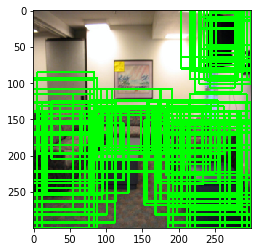

Shape: (300, 300, 3) Boxes: tensor([ 0, 16, 19, 20])
>>>>>>>>>>> tensor(5)


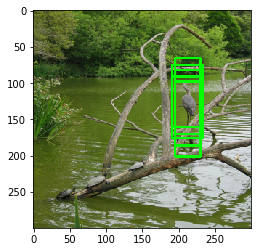

Shape: (300, 300, 3) Boxes: tensor([0, 2])
>>>>>>>>>>> tensor(19)


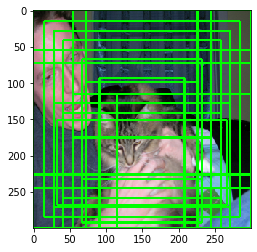

Shape: (300, 300, 3) Boxes: tensor([0, 1, 3])
>>>>>>>>>>> tensor(14)


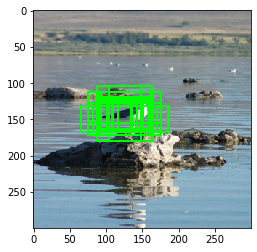

Shape: (300, 300, 3) Boxes: tensor([0, 2])
>>>>>>>>>>> tensor(41)


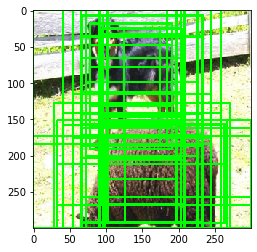

Shape: (300, 300, 3) Boxes: tensor([0, 5, 7])
>>>>>>>>>>> tensor(12)


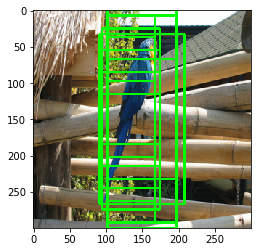

Shape: (300, 300, 3) Boxes: tensor([0, 2])
>>>>>>>>>>> tensor(11)


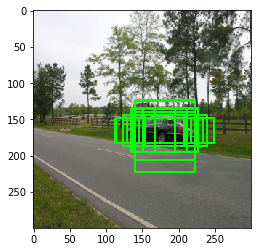

Shape: (300, 300, 3) Boxes: tensor([ 0, 12])
>>>>>>>>>>> tensor(39)


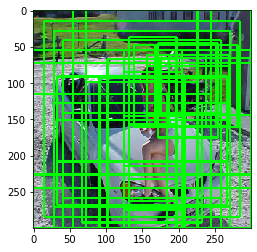

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 12, 13])
>>>>>>>>>>> tensor(32)


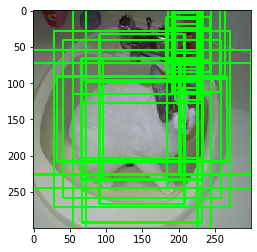

Shape: (300, 300, 3) Boxes: tensor([ 0,  3, 15])
>>>>>>>>>>> tensor(43)


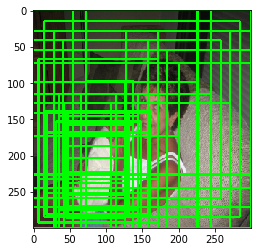

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 19])
>>>>>>>>>>> tensor(15)


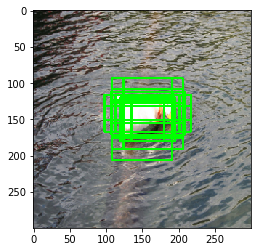

Shape: (300, 300, 3) Boxes: tensor([0, 2])
>>>>>>>>>>> tensor(21)


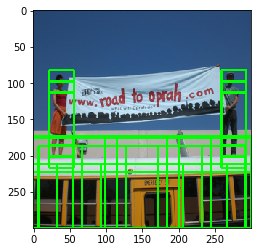

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 11])
>>>>>>>>>>> tensor(14)


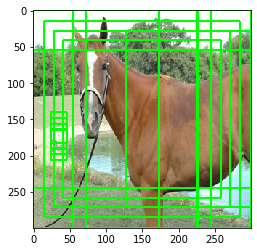

Shape: (300, 300, 3) Boxes: tensor([0, 1, 6])
>>>>>>>>>>> tensor(34)


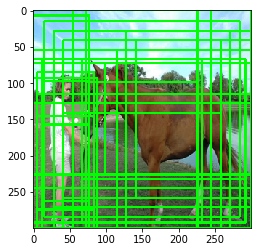

Shape: (300, 300, 3) Boxes: tensor([0, 1, 6])
>>>>>>>>>>> tensor(51)


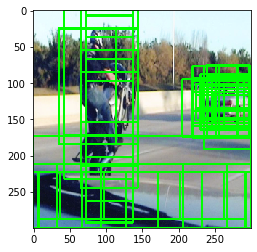

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 12, 13])
>>>>>>>>>>> tensor(24)


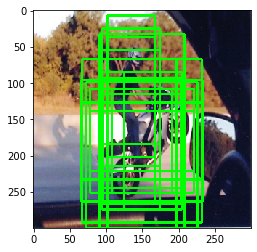

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 13])
>>>>>>>>>>> tensor(21)


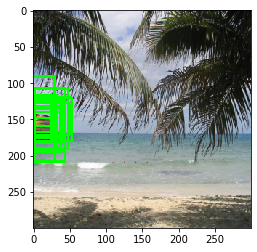

Shape: (300, 300, 3) Boxes: tensor([ 0, 10])
>>>>>>>>>>> tensor(5)


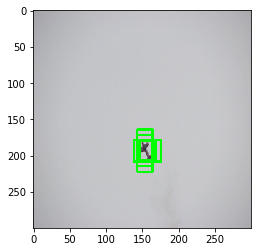

Shape: (300, 300, 3) Boxes: tensor([0, 8])
>>>>>>>>>>> tensor(12)


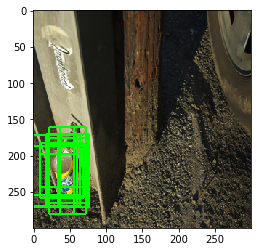

Shape: (300, 300, 3) Boxes: tensor([ 0, 15])
>>>>>>>>>>> tensor(10)


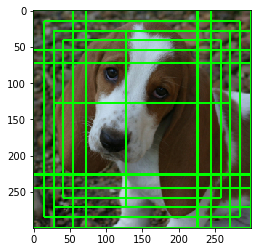

Shape: (300, 300, 3) Boxes: tensor([0, 5])
>>>>>>>>>>> tensor(15)


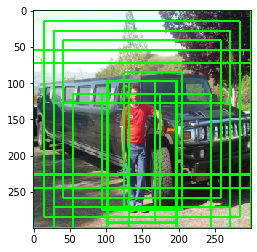

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 12])
>>>>>>>>>>> tensor(16)


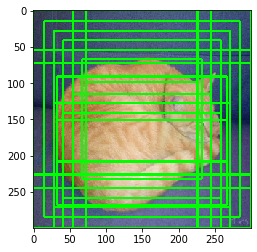

Shape: (300, 300, 3) Boxes: tensor([0, 3])
>>>>>>>>>>> tensor(23)


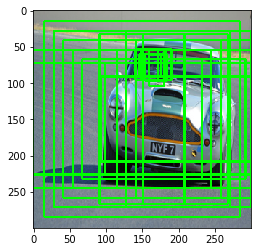

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 12])
>>>>>>>>>>> tensor(12)


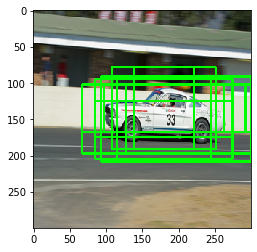

Shape: (300, 300, 3) Boxes: tensor([ 0, 12])
>>>>>>>>>>> tensor(17)


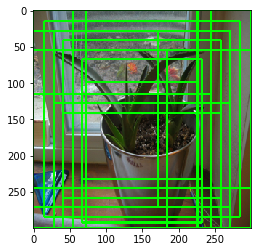

Shape: (300, 300, 3) Boxes: tensor([ 0, 18])
>>>>>>>>>>> tensor(28)


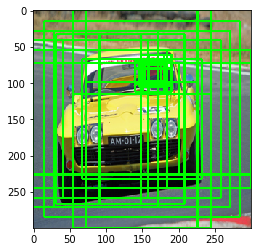

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 12])
>>>>>>>>>>> tensor(18)


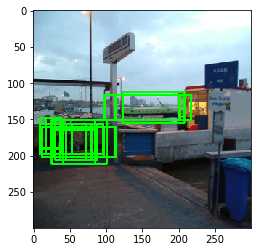

Shape: (300, 300, 3) Boxes: tensor([ 0,  1,  9, 10])
>>>>>>>>>>> tensor(26)


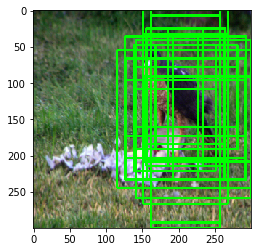

Shape: (300, 300, 3) Boxes: tensor([0, 2])
>>>>>>>>>>> tensor(9)


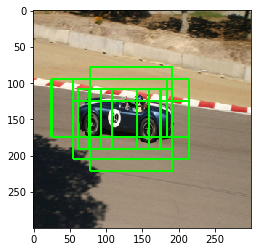

Shape: (300, 300, 3) Boxes: tensor([ 0, 12])
>>>>>>>>>>> tensor(79)


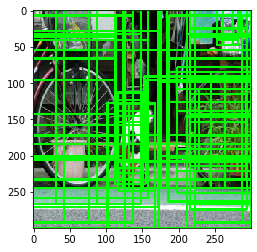

Shape: (300, 300, 3) Boxes: tensor([ 0,  3,  9, 15, 18])
>>>>>>>>>>> tensor(11)


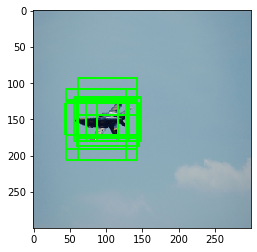

Shape: (300, 300, 3) Boxes: tensor([0, 8])
>>>>>>>>>>> tensor(24)


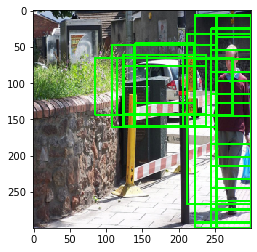

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 12])
>>>>>>>>>>> tensor(92)


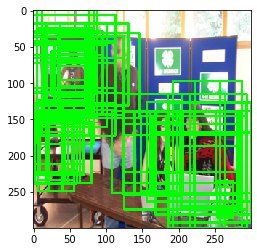

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 15, 16, 20])
>>>>>>>>>>> tensor(16)


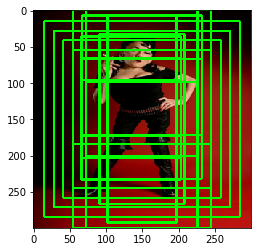

Shape: (300, 300, 3) Boxes: tensor([0, 1])
>>>>>>>>>>> tensor(19)


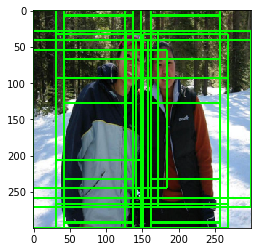

Shape: (300, 300, 3) Boxes: tensor([0, 1])
>>>>>>>>>>> tensor(17)


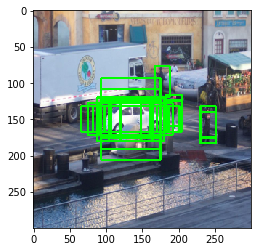

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 12])
>>>>>>>>>>> tensor(55)


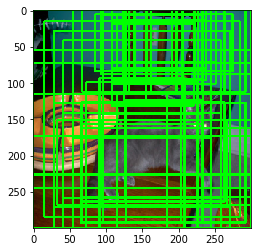

Shape: (300, 300, 3) Boxes: tensor([ 0,  3, 16, 17])
>>>>>>>>>>> tensor(22)


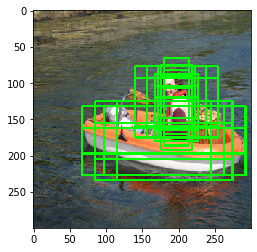

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 10])
>>>>>>>>>>> tensor(18)


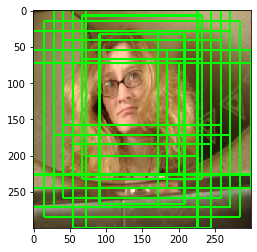

Shape: (300, 300, 3) Boxes: tensor([0, 1])
>>>>>>>>>>> tensor(40)


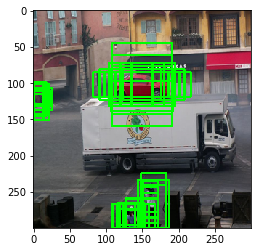

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 12, 13])
>>>>>>>>>>> tensor(12)


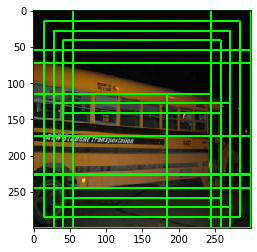

Shape: (300, 300, 3) Boxes: tensor([ 0, 11])
>>>>>>>>>>> tensor(64)


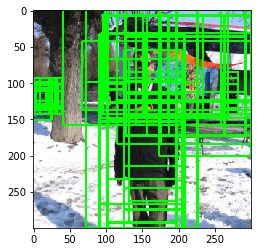

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 11, 12])
>>>>>>>>>>> tensor(2)


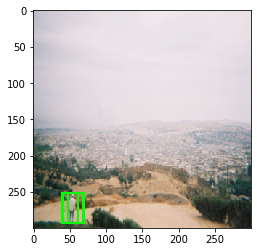

Shape: (300, 300, 3) Boxes: tensor([0, 1])
>>>>>>>>>>> tensor(16)


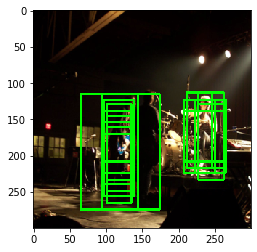

Shape: (300, 300, 3) Boxes: tensor([0, 1])
>>>>>>>>>>> tensor(85)


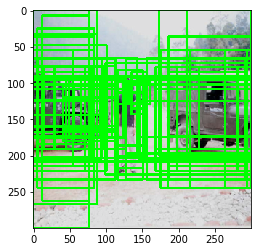

Shape: (300, 300, 3) Boxes: tensor([ 0,  1, 12])
>>>>>>>>>>> tensor(18)


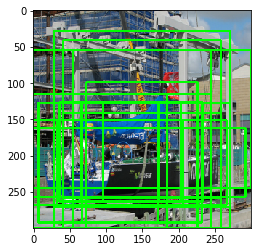

Shape: (300, 300, 3) Boxes: tensor([ 0, 10])
>>>>>>>>>>> tensor(53)


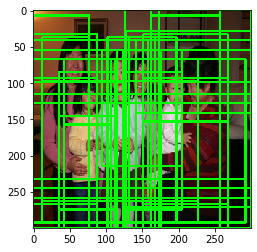

Shape: (300, 300, 3) Boxes: tensor([0, 1])


In [0]:
ds = datasets.VOCDetection('./voc', transforms=SSDTransformVoc((300,300),create_prior_boxes(),augmentation=False),download=True)
# ds = PennFudanDataset('./PennFudanPed', transforms=SSDTransformVoc(dboxes))
test_dataloading(ds)

In [0]:
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
def freeze_layers(layer):
      if isinstance(layer, nn.BatchNorm2d):
            layer.eval()
class Resnet(nn.Module):
  def get_feats(self,x):
    res=[]
    for name,module in self.model.named_children():
        x=module(x)
        if name in self.layers:
            res.append(x)
        if name =='layer4':
            break
    return res
  def __init__(self,freez):
    super(Resnet, self).__init__()
    model = models.resnet50(pretrained=True)#EfficientNet.from_pretrained('efficientnet-b2') 
    #model.extract = types.MethodType(extract_features_midconv, model)#models.resnet18(pretrained=True)
    self.model=model
    self.layers = ['layer2','layer3','layer4']
    for name, parameter in self.named_parameters():
            if 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
              parameter.requires_grad_(False)
    self.apply(freeze_layers)
  def forward(self,x):
    return self.get_feats(x)#self.model.extract(x)
  def forward1(self,x):
    out = []
    i=0
    for name,module in self.model.named_children():
      x = module(x)
      if name in self.layers:
        out.append(x)
      if len(out)==len(self.layers):
        break

    return out
class FPN(nn.Module):
    def __init__(self,in_layers,out_layer):
        super(FPN, self).__init__()

        in_modules = []
        out_modules = []
        out_modules.append(nn.Conv2d(in_layers[0],out_layer,3,padding=1))
        for i in range(len(in_layers)-1):
            in_modules.append(nn.Conv2d(in_layers[i],in_layers[i+1],1))
            out_modules.append(nn.Conv2d(in_layers[i+1],out_layer,3,padding=1))
        self.out_modules = nn.ModuleList(out_modules)
        self.in_modules  =nn.ModuleList(in_modules)
        
        for m in self.children():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                nn.init.constant_(m.bias, 0)
    def forward(self,x):
        res = [self.out_modules[0](x[0])]
        in_=x[0]
        for i in range(len(x)-1):
            #print(in_.size())
            in_ = x[i+1]+ F.interpolate(self.in_modules[i](in_), size=x[i+1].shape[-2:], mode="nearest")
            res.append(self.out_modules[i+1](in_))
        #for i in res:
        #    print(i.size())
        return res
class AuxiliaryConvolutions(nn.Module):
  def __init__(self):
    super(AuxiliaryConvolutions, self).__init__()
    self.conv3 = nn.Conv2d(2048,256,1,1)
    self.conv4 = nn.Conv2d(256,512,3,stride=2,padding=1)

    self.conv5 = nn.Conv2d(512,256,1,1)
    self.conv6 = nn.Conv2d(256,512,3,stride=2,padding=1)

    self.conv7 = nn.Conv2d(512,256,1,1)
    self.conv8 = nn.Conv2d(256,512,3,stride=1)
    self.apply(init_cnn)

  def forward(self,out2,out3,out4):
    x=F.relu(self.conv3(out4))
    out5=F.relu(self.conv4(x))
    
    x=F.relu(self.conv5(out5))
    out6=F.relu(self.conv6(x))
    
    x=F.relu(self.conv7(out6))
    out7=F.relu(self.conv8(x))
    return out2,out3,out4,out5,out6,out7
class PredictionNetwork(nn.Module):
  def __init__(self,classes):
    #24, 75, 75]) torch.Size([1, 48, 37, 37]) torch.Size([1, 120, 18, 18]) torch.Size([1, 1408, 9, 9])
    #torch.Size([1, 256, 5, 5]) torch.Size([1, 256, 3, 3]) torch.Size([1, 256, 2, 2])
    super(PredictionNetwork, self).__init__()
    self.classes = classes
    #self.detect_75 = nn.Conv2d(24,4*4,3,padding=1)
    #self.labels_75 = nn.Conv2d(24,4*(classes),3,padding=1)
    
    self.detect_38 = nn.Conv2d(512,4*4,3,padding=1)
    self.labels_38 = nn.Conv2d(512,4*(classes),3,padding=1)

    self.detect_19 = nn.Conv2d(1024,6*4,3,padding=1)
    self.labels_19 = nn.Conv2d(1024,6*(classes),3,padding=1)


    self.detect_10 = nn.Conv2d(2048,6*4,3,padding=1)
    self.labels_10 = nn.Conv2d(2048,6*(classes),3,padding=1)


    self.detect_5 = nn.Conv2d(512,6*4,3,padding=1)
    self.labels_5 = nn.Conv2d(512,6*(classes),3,padding=1)

    self.detect_3 = nn.Conv2d(512,4*4,3,padding=1)
    self.labels_3 = nn.Conv2d(512,4*(classes),3,padding=1)

    self.detect_1 = nn.Conv2d(512,4*4,3,padding=1)
    self.labels_1 = nn.Conv2d(512,4*(classes),3,padding=1)
    self.apply(init_cnn)
  def forward(self,out1,out2,out3,out4,out5,out6):
      #print(out1.size(),out2.size(),out3.size(),out4.size(),out5.size(),out6.size())
      batch_size = out1.size(0)
    
      #det75 = self.detect_75(out0)
      #det75 = det75.permute(0, 2, 3,1).contiguous().view(batch_size,-1,4)

      #lab75 = self.labels_75(out0)
      #lab75 = lab75.permute(0, 2, 3,1).contiguous().view(batch_size,-1,self.classes)


    
      det38 = self.detect_38(out1)
      det38 = det38.permute(0, 2, 3,1).contiguous().view(batch_size,-1,4)

      lab38 = self.labels_38(out1)
      lab38 = lab38.permute(0, 2, 3,1).contiguous().view(batch_size,-1,self.classes)


      det19 = self.detect_19(out2)
      det19 = det19.permute(0, 2, 3,1).contiguous().view(batch_size,-1,4)

      lab19 = self.labels_19(out2)
      lab19 = lab19.permute(0, 2, 3,1).contiguous().view(batch_size,-1,self.classes)

      det10 = self.detect_10(out3)
      det10 = det10.permute(0, 2, 3,1).contiguous().view(batch_size,-1,4)


      lab10 = self.labels_10(out3)
      lab10 = lab10.permute(0, 2, 3,1).contiguous().view(batch_size,-1,self.classes)

      det5 = self.detect_5(out4)
      det5 = det5.permute(0, 2, 3,1).contiguous().view(batch_size,-1,4)

      lab5 = self.labels_5(out4)
      lab5 = lab5.permute(0, 2, 3,1).contiguous().view(batch_size,-1,self.classes)

      det3 = self.detect_3(out5)
      det3 = det3.permute(0, 2, 3,1).contiguous().view(batch_size,-1,4)


      lab3 = self.labels_3(out5)
      lab3 = lab3.permute(0, 2, 3,1).contiguous().view(batch_size,-1,self.classes)
      
      det1 = self.detect_1(out6)
      det1 = det1.permute(0, 2, 3,1).contiguous().view(batch_size,-1,4)
      


      lab1 = self.labels_1(out6)
      lab1 = lab1.permute(0, 2, 3,1).contiguous().view(batch_size,-1,self.classes)
      return torch.cat([lab38,lab19,lab10,lab5,lab3,lab1],dim=1),torch.cat([det38,det19,det10,det5,det3,det1],dim=1)
class SSD(nn.Module):
  def __init__(self,head,auxiliary,prediction):
    super(SSD, self).__init__()
    self.head=head
    self.auxiliary=auxiliary
    #self.fpn=fpn
    self.prediction=prediction
  def forward(self,x):
    out1,out2,out3 = self.head(x)
    x2,x3,x4,x5,x6,x7=self.auxiliary(out1,out2,out3)
    #print(x2.size(),x3.size(),x4.size(),x5.size(),x6.size(),x7.size())
    #res=self.fpn([x2,x3,x4,x5,x6,x7][::-1])[::-1]
    res1,res2=self.prediction(x2,x3,x4,x5,x6,x7)
    return res1,res2

In [9]:
%%time
model = Resnet(True)
model1 = AuxiliaryConvolutions()
model2 = PredictionNetwork(classes=21)
#fpn = FPN([48,120,1408,512,512,512][::-1],512)
ssd = SSD(model,model1,model2)
res1,res2=ssd(torch.rand(8,3,300,300))
print(res1.size(),res2.size())

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 290MB/s]


torch.Size([8, 8732, 21]) torch.Size([8, 8732, 4])
CPU times: user 3.16 s, sys: 905 ms, total: 4.07 s
Wall time: 4.31 s


In [0]:
class FocalLoss(nn.Module):

    def __init__(self, gamma=2, size_average=False):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.size_average = size_average
        self.ce = nn.CrossEntropyLoss(reduction='none')
    def forward(self, input, target):
        ce = self.ce(input,target)
        pt = (-1*ce).exp()
        loss = (1 - pt)**self.gamma * ce
        if self.size_average: 
            return loss.mean()
        else: 
            return loss

class Loss(nn.Module):

    def __init__(self):
      super(Loss,self).__init__()
      self.focal = FocalLoss(size_average=False)
      self.regr = nn.SmoothL1Loss(reduction='none')

    def forward(self,ploc,plabel,gloc,glabel):
      bs = ploc.size(0)
      mask = glabel>0
      num_pos = mask.sum(dim=1)
      #print(mask.size(),ploc.size(),gloc.size())
      l1_loss =(self.regr(ploc,gloc).sum(dim=2)*mask.float()).sum(dim=1)
      
      label_loss = self.focal(plabel.permute(0,2,1),glabel)#*super_neg.float()).sum(dim=1)/(mask.float().sum(dim=1))
      neg = label_loss.clone()
      neg[mask]=0
    
      for i in range(bs): 
        vals,inds=torch.topk(neg[i], num_pos[i]*3, dim=0)
        mask[i,inds]=True
      label_loss =(label_loss*mask.float()).sum(dim=1)#.sum(dim=1)
      #print('>>>>>>><',label_loss,l1_loss,num_pos)
      total_loss = (label_loss/num_pos.float().clamp(min=1)).mean(dim=0)+l1_loss.mean(dim=0)
      return total_loss,label_loss.detach().mean(),l1_loss.detach().mean()

In [11]:
for qre,target in DataLoader(ds,batch_size=2):
  break
boxes,labels,for_loss = target
rboxes,rlabels = w,q
loss2 = Loss()
qq,ee,ww=loss2.forward(rboxes,rlabels,for_loss.type(torch.FloatTensor),labels)
print('-------',qq,ww,ee)

NameError: ignored

In [0]:
q.size(),w.size()

NameError: ignored

In [12]:
# training can take time more then Colab instance life so we can use small hack to save our weights in safe store
# we will use Google Drive for thhat
from google.colab import drive
# now your google drive on path ./drive
drive.mount('./drive')#4/uAFCOhIK_j_U2A-reT_McXh_AI83bjnTJJL5sowB586ZlHSW4U5SiE4

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./drive


In [13]:
model =  ssd
state = torch.load('drive/My Drive/ssd300.pth',map_location=torch.device('cpu'))
model.load_state_dict(state)

<All keys matched successfully>

In [0]:
device = torch.device("cuda")
ssd.to(device)

In [0]:
ssd.to(device)

In [0]:
device = torch.device("cuda")
#torch.autograd.set_detect_anomaly(True)
torch.manual_seed(42)

#ds = PennFudanDataset('./PennFudanPed', transforms=SSDTransformVoc(dboxes, augmentation=True))
ds = datasets.VOCDetection('./voc', transforms=SSDTransformVoc(priors = create_prior_boxes(),augmentation=True))

loader = DataLoader(ds, batch_size=8, pin_memory=True, drop_last=True,shuffle=True) 
epochs =  70# its enough to see good result
model =  ssd
state = torch.load('drive/My Drive/ssd300.pth',map_location=torch.device('cpu'))
model.load_state_dict(state)
model = model.to(device)
loss_f = Loss()#(device)

optimizer = optim.Adam(model.parameters(), lr=(1e-6), weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
print('------')
st = time.time()
model.train()
for e in range(epochs):
    t = 0
    loss_avg = 0
    loc_loss=0
    class_loss=0
    for i, (img, target) in enumerate(loader):
        img = img.to(device)
        boxes,labels ,for_loss= target[0].to(device), target[1].to(device), target[2].type(torch.FloatTensor).to(device)
        # before each iteration we clear all gradients calculated before 
        optimizer.zero_grad()
        rlabels,rboxes = model(img)
        loss,labs,locs= loss_f(rboxes,rlabels,for_loss,labels)
  
        
        # calculating gradients
        loss.backward()
        # optimizing

        optimizer.step()
        # .item() is simple way to get value from scalar
        loss_avg += loss.item()
        loc_loss+=locs.item()
        class_loss+=labs.item()
        t += 1
    print(f'Epoch: {e}/{epochs} loc_loss:{loc_loss/t} class_loss:{class_loss/t} Loss:{loss_avg/t}, LR:{optimizer}')
    try:
        torch.save(model.state_dict(), 'drive/My Drive/ssd300.pth')
    except KeyboardInterrupt as e:
        print('SAVING !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        torch.save(model.state_dict(), 'drive/My Drive/ssd300.pth')
        raise e
    scheduler.step(loss_avg/t)    
print('Training time:', time.time()-st)

------
Epoch: 0/70 loc_loss:0.42474808910710304 class_loss:12.114050150001082 Loss:0.6377517790729258, LR:Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-06
    weight_decay: 0.0005
)
Epoch: 1/70 loc_loss:0.4324999536369361 class_loss:12.064787932136813 Loss:0.6452779265470198, LR:Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-06
    weight_decay: 0.0005
)
Epoch: 2/70 loc_loss:0.42577293820428747 class_loss:12.030854322245808 Loss:0.6377331098484225, LR:Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-06
    weight_decay: 0.0005
)
Epoch: 3/70 loc_loss:0.42736182892460284 class_loss:12.092612466057476 Loss:0.6400127940046854, LR:Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-06
    weight_decay: 0.0005
)
Epoch: 4/70 loc_loss:0.4210630320221269 class_loss:11.971533666137887 Loss:0.6323373163593751, LR:Adam

KeyboardInterrupt: ignored

In [0]:
# we use batches_nms cause we can have many classes of different objects
from torchvision.ops.boxes import batched_nms

def test(model_path, model_class, bu, input, num=6, thresh=0.5, iou_threshold=0.5, size=300, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    classes = [
        "bg","person", "bird", "cat", "cow", "dog", "horse", "sheep",
        "aeroplane", "bicycle", "boat", "bus", "car", "motorbike", "train",
        "bottle", "chair", "diningtable", "pottedplant", "sofa", "tvmonitor"
    ]

    def denorm(x):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        return (x * std) + mean

    #state = torch.load(model_path)
    model = model_class.cpu()
    #model.load_state_dict(state)
    model.eval()
    img_ts = transforms.Compose([
        transforms.Resize((size,size)),
        transforms.ToTensor(), # converts to [0,1] interval
        transforms.Normalize(mean=mean, std=std)
    ])  
    total = 0
    iou_avg = 0
    if isinstance(input, Image.Image):
        input = [[img_ts(input), None]]
    for img, target in input:
        print(img.size())
        img = img.view(1,3,300,300)
        st = time.time()
        rlabels,rboxes = model(img)
        print('Inference time:', time.time()-st)
        st = time.time()
        #rlabels = rlabels.permute(0,2,1)
        #rboxes=rboxes.permute(0,2,1)
        rboxes, rlabels = rboxes[0], rlabels[0].transpose(1,0)
        img = (denorm(img[0].numpy().transpose(1,2,0).copy())*255).astype(np.uint8)
        w,h = img.shape[:2]
        #print(anchors.generate_anchors(np.array([300,300])).size(),rboxes.size())
        bboxes = cxcy_to_xy(gcxgcy_to_cxcy(rboxes,create_prior_boxes()))#.to(torch.device('cpu'))
        scores, labels = F.softmax(rlabels, dim=0).max(dim=0)
        print(labels.unique())
        mask = (labels > 0)
        labels = labels[mask]
        scores = scores[mask]
        bboxes = bboxes[mask]
        # print(scores)
        mask = (scores > thresh)
        labels = labels[mask]
        scores = scores[mask]
        bboxes = bboxes[mask]
        
        
        print('Boxes:',bboxes.shape[0])
        print('Mod time:', time.time()-st)
        st = time.time()
        idx = batched_nms(bboxes.type(torch.FloatTensor), scores.type(torch.FloatTensor), labels, iou_threshold=iou_threshold).numpy().astype(np.uint64)
        print('NMS time:', time.time()-st)
        labels = labels.detach().numpy().astype(np.uint8)
        scores = scores.detach().numpy()
        bboxes = bboxes.detach().numpy()
    
        for i in idx:
            b = bboxes[i] 
            img = cv2.rectangle(img, (int(b[0]*size), int(b[1]*size)), (int(b[2]*size), int(b[3]*size)), (0, 255, 0), 2)
            print(int(b[0]*size), int(b[1]*size), int(b[2]*size), int(b[3]*size), classes[labels[i]], scores[i])
                        
        
        plt.imshow(img)
        plt.show()

        total += 1
        if total >= num:
            break

Inference time: 1.1942369937896729
tensor([0, 1, 6])
Boxes: 28
Mod time: 0.031050682067871094
NMS time: 0.00036072731018066406
29 59 281 284 horse 0.9688386
94 27 173 111 person 0.9439325


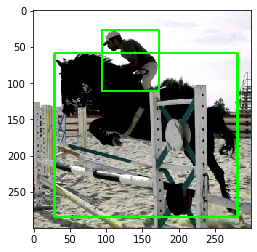

Inference time: 1.3508620262145996
tensor([ 0, 15])
Boxes: 28
Mod time: 0.025447607040405273
NMS time: 0.0002491474151611328
162 0 226 169 bottle 0.97612476
34 0 97 140 bottle 0.9712002


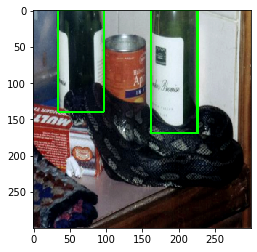

Inference time: 1.1568694114685059
tensor([0, 3, 5, 7])
Boxes: 70
Mod time: 0.029786348342895508
NMS time: 0.0003752708435058594
85 0 232 212 dog 0.9889965
228 0 300 124 dog 0.9886532
103 73 198 259 dog 0.9873655


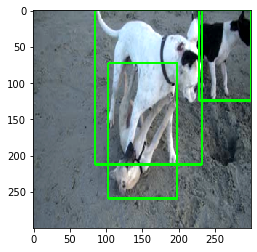

Inference time: 1.1471834182739258
tensor([ 0, 15, 20])
Boxes: 32
Mod time: 0.0811469554901123
NMS time: 0.00025725364685058594
191 58 263 246 bottle 0.9793148
18 0 294 156 tvmonitor 0.9791065


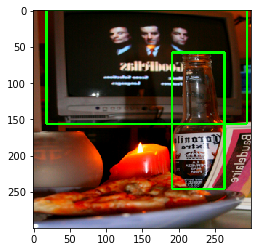

KeyboardInterrupt: ignored

In [0]:
lbs=test('./ssd300.pth', model, 2, ds, size=300, thresh=0.5,num=10)

torch.Size([3, 300, 300])
Inference time: 1.2549774646759033
tensor([0, 5])
Boxes: 35
Mod time: 0.12389135360717773
NMS time: 0.0006420612335205078
153 74 268 268 dog 0.965829
41 77 168 258 dog 0.84632087


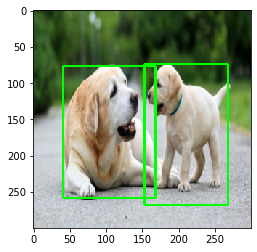

In [18]:
lbs=test('./ssd300.pth', model, 2, Image.open('drive/My Drive/dogs1.jpg'), size=300, thresh=0.5)

torch.Size([3, 300, 300])
Inference time: 1.167288064956665
tensor([0, 5])
Boxes: 28
Mod time: 0.028327226638793945
NMS time: 0.0003161430358886719
153 30 277 265 dog 0.9948606
48 13 147 257 dog 0.9790483
71 27 223 262 dog 0.8957986


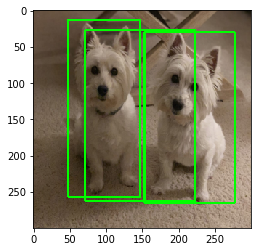

In [19]:
lbs=test('./ssd300.pth', model, 2, Image.open('drive/My Drive/dogs2.jpg'), size=300, thresh=0.5)

torch.Size([3, 300, 300])
Inference time: 1.173658847808838
tensor([ 0,  1, 12, 13])
Boxes: 10
Mod time: 0.02654862403869629
NMS time: 0.0003426074981689453
140 77 195 271 person 0.85056275
52 116 248 300 car 0.84126407


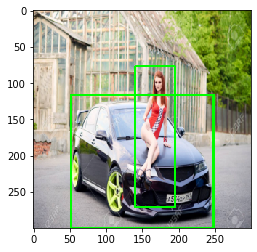

In [20]:
lbs=test('./ssd300.pth', model, 2, Image.open('drive/My Drive/car.jpg'), size=300, thresh=0.5)